D-Wave Inspector enabled.


Serving Inspector on http://127.0.0.1:18000/?problemId=4d0a0912-8bcb-453e-8d63-2e9377e26fa4

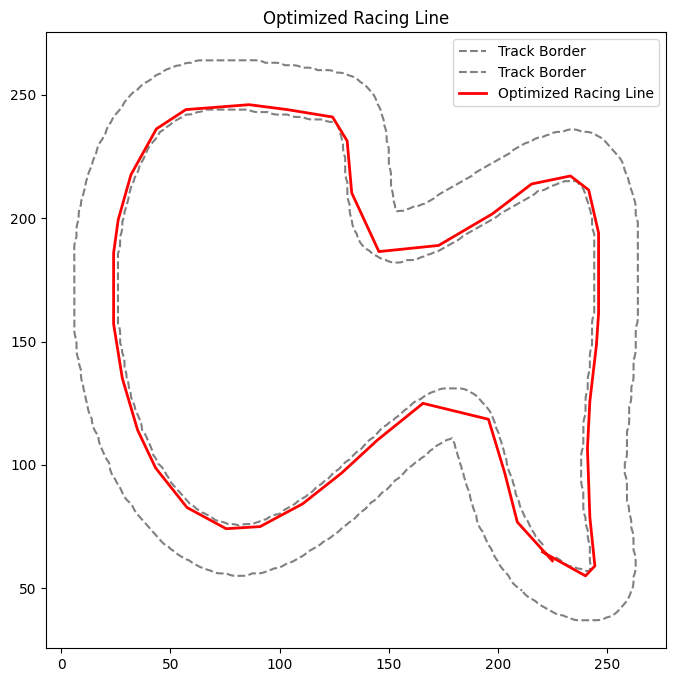

In [ ]:
import math
import json
import numpy as np
from scipy import interpolate
from shapely.geometry import LineString
from dwave.system import DWaveSampler, EmbeddingComposite
from dimod import BinaryQuadraticModel
import matplotlib.pyplot as plt

# Import D-Wave Inspector
try:
    import dwave.inspector
    inspector_available = True
    print("D-Wave Inspector enabled.")
except ImportError:
    inspector_available = False
    print("D-Wave Inspector is not installed. Install it using `pip install dwave-inspector`.")


def plot_lines(track_lines, racing_line, title="Track"):
    """Plot track lines and overlay racing line."""
    plt.figure(figsize=(8, 8))

    # Plot track lines (inside and outside)
    for line in track_lines:
        x, y = line.xy
        plt.plot(x, y, label="Track Border", color="grey", linestyle="--")

    # Plot optimized racing line
    x_racing, y_racing = racing_line.xy
    plt.plot(x_racing, y_racing, label="Optimized Racing Line", color="red", linewidth=2)

    plt.title(title)
    plt.legend(loc="best")
    plt.show()


def get_closest_points(point, array):
    """Find the closest point in an array."""
    distance = float('inf')
    closest_point = None
    for arr_point in array:
        temp_distance = np.linalg.norm(np.array(point) - np.array(arr_point))
        if temp_distance < distance:
            distance = temp_distance
            closest_point = arr_point
    return closest_point


def sectors_to_racing_line(sectors, inside_points, outside_points):
    """Convert sector values to Cartesian coordinates."""
    racing_line = []
    for i, sector in enumerate(sectors):
        inside = np.array(inside_points[i])
        outside = np.array(outside_points[i])
        racing_line.append((1 - sector) * inside + sector * outside)
    return np.array(racing_line)


def get_lap_time(racing_line, return_all=False):
    """Calculate lap time for a given racing line."""
    tck, _ = interpolate.splprep([racing_line[:, 0], racing_line[:, 1]], s=0.0, per=0)
    x, y = interpolate.splev(np.linspace(0, 1, 1000), tck)

    # Derivatives for curvature
    dx, dy = np.gradient(x), np.gradient(y)
    d2x, d2y = np.gradient(dx), np.gradient(dy)
    curvature = np.abs(dx * d2y - dy * d2x) / (dx**2 + dy**2)**1.5
    radius = np.clip(1 / curvature, 1e-5, None)  # Avoid division by zero

    # Speed and lap time calculation
    friction = 0.13  # Coefficient of friction
    speeds = np.sqrt(friction * radius * 9.81)
    lap_time = np.sum(np.sqrt(np.diff(x)**2 + np.diff(y)**2) / speeds[:-1])

    if return_all:
        return lap_time, speeds, x, y
    return lap_time


def racing_line_qannealing(center_line, inside_line, outside_line, num_sectors=50, num_samples=1000, plot=True):
    """Optimize racing line using quantum annealing."""
    # Define sectors
    distances = np.linspace(0, center_line.length, num_sectors)
    center_points = [center_line.interpolate(dist) for dist in distances]
    center_points = np.array([[p.x, p.y] for p in center_points])

    inside_points = [
        get_closest_points(pt, np.array(inside_line.coords)) for pt in center_points
    ]
    outside_points = [
        get_closest_points(pt, np.array(outside_line.coords)) for pt in center_points
    ]

    # QUBO Construction
    num_variables = num_sectors * 10  # 10 binary variables per sector for discretization
    step_size = 1 / 10  # Each binary variable represents 0.1 of the sector width

    bqm = BinaryQuadraticModel('BINARY')

    # Objective: Minimize lap time
    for sector_idx in range(num_sectors):
        for i in range(10):
            weight = step_size * (i + 0.5)  # Midpoint value for binary variables
            bqm.add_variable(sector_idx * 10 + i, weight)

    # Constraints: One-hot encoding (only one binary variable per sector can be 1)
    for sector_idx in range(num_sectors):
        sector_vars = [sector_idx * 10 + i for i in range(10)]
        bqm.add_linear_equality_constraint(
            [(var, 1) for var in sector_vars], constant=-1, lagrange_multiplier=10
        )

    # Run on D-Wave
    sampler = EmbeddingComposite(DWaveSampler(token="TOKEN GOES HERE"))  # Replace with your API key
    sampleset = sampler.sample(bqm, num_reads=num_samples)

    # Open the Inspector with the sampleset if available
    if inspector_available:
        dwave.inspector.show(sampleset)  # This will open the Inspector in your default browser

    # Extract best solution
    best_solution = sampleset.first.sample
    sectors = [
        sum((best_solution[sector_idx * 10 + i] * step_size for i in range(10)))
        for sector_idx in range(num_sectors)
    ]

    # Generate racing line
    racing_line = sectors_to_racing_line(sectors, inside_points, outside_points)

    # Plot final racing line
    if plot:
        plot_lines([inside_line, outside_line], LineString(racing_line), title="Optimized Racing Line")

    return racing_line


def main():
    # Load track data
    with open("data/tracks.json") as file:
        data = json.load(file)
    track_data = data["test_track"]

    # Extract track layout
    track_layout = np.array(track_data["layout"])
    track_width = track_data["width"]

    # Create track borders
    center_line = LineString(track_layout)
    inside_line = center_line.parallel_offset(track_width / 2, 'left')
    outside_line = center_line.parallel_offset(track_width / 2, 'right')

    # Run optimization
    racing_line = racing_line_qannealing(center_line, inside_line, outside_line)


if __name__ == "__main__":
    main()
